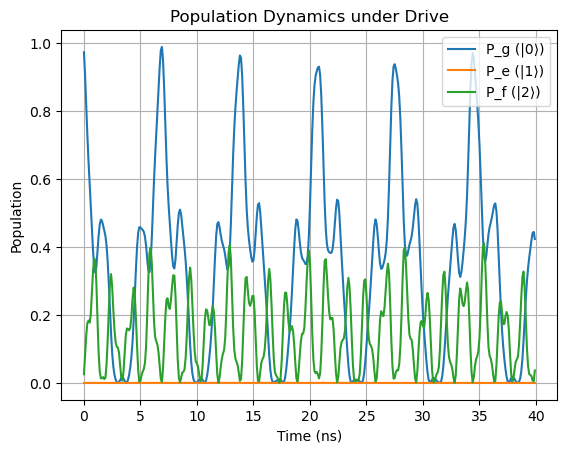

In [ ]:
# Jupyter Notebook: Driven Qubit Dynamics Simulation


## Step 2: Static Hamiltonian Construction
def build_static_hamiltonian(EC, EJ, EL, N, n_cutoff=20):
    n_vals = np.arange(-n_cutoff, n_cutoff + 1)
    dim = len(n_vals)
    n_op = diags(n_vals, 0).toarray()
    exp_i_phi = diags([np.ones(dim - 1)], [1], shape=(dim, dim)).toarray()
    exp_minus_i_phi = diags([np.ones(dim - 1)], [-1], shape=(dim, dim)).toarray()
    cos_phi_op = 0.5 * (exp_i_phi + exp_minus_i_phi)
    H0 = 4 * EC * (n_op @ n_op) + EJ * cos_phi_op
    evals, evecs = np.linalg.eigh(H0)
    evals = evals[:N]
    evecs = evecs[:, :N]
    n_op_trunc = evecs.T @ n_op @ evecs
    phi_vals = np.linspace(-np.pi, np.pi, dim)
    phi_op = diags(phi_vals, 0).toarray()
    phi_op_trunc = evecs.T @ phi_op @ evecs
    return evals, evecs, n_op_trunc, phi_op_trunc

## Step 3: Define Drive Flux Function
def phi_drive(t, phi_amp, omega_d, envelope_fn):
    return 2 * np.pi * phi_amp * envelope_fn(t) * np.cos(2 * np.pi * omega_d * t)

def sine_squared_envelope(t, t_pulse):
    return np.sin(np.pi * t / t_pulse)**2 if 0 <= t <= t_pulse else 0.0

## Step 4: Time-Dependent Hamiltonian
def H_time_dependent(phi_t, EC, EJ, EL, n_op, phi_op):
    H_static = 4 * EC * (n_op @ n_op) + EJ * expm(1j * phi_op).real
    phi_shift = phi_op - phi_t * np.eye(phi_op.shape[0])
    H_drive = 0.5 * EL * (phi_shift @ phi_shift)
    return H_static + H_drive

## Step 5: Time Evolution Step
def time_evolve_step(psi_t, H_t, dt):
    U = expm(-1j * H_t * dt)
    return U @ psi_t

## Step 6: Full Simulation Function
def simulate_time_evolution(psi_0, times, phi_amp, omega_d, envelope_fn,
                            EC, EJ, EL, n_op, phi_op):
    psi_t = psi_0.copy()
    for t in times:
        phi_t = phi_drive(t, phi_amp, omega_d, envelope_fn)
        H_t = H_time_dependent(phi_t, EC, EJ, EL, n_op, phi_op)
        dt = times[1] - times[0]
        psi_t = time_evolve_step(psi_t, H_t, dt)
        psi_t /= np.linalg.norm(psi_t)
    return psi_t

## Step 7: Measure State Populations
def excited_state_population(psi_final, excited_state):
    return np.abs(np.vdot(excited_state, psi_final))**2

## Step 8: Explore Dynamics of |g>, |e>, |f>
def explore_dynamics(psi_0, evecs, times, phi_amp, omega_d, envelope_fn,
                     EC, EJ, EL, n_op, phi_op):
    psi_t = psi_0.copy()
    P_g, P_e, P_f = [], [], []
    for t in times:
        phi_t = phi_drive(t, phi_amp, omega_d, envelope_fn)
        H_t = H_time_dependent(phi_t, EC, EJ, EL, n_op, phi_op)
        dt = times[1] - times[0]
        psi_t = time_evolve_step(psi_t, H_t, dt)
        psi_t /= np.linalg.norm(psi_t)
        P_g.append(np.abs(psi_t[0])**2)
        P_e.append(np.abs(psi_t[1])**2)
        P_f.append(np.abs(psi_t[2])**2)
    return times, np.array(P_g), np.array(P_e), np.array(P_f)

## Step 9: Simulation Parameters and Run
EC = 0.25
EJ = 20.0
EL = 1.0
N = 10
phi_amp = 0.5
t_pulse = 40
omega_d = 5.8
envelope = lambda t: sine_squared_envelope(t, t_pulse)
evals, evecs, n_op_trunc, phi_op_trunc = build_static_hamiltonian(EC, EJ, EL, N)
psi_0_trunc = evecs.T @ evecs[:, 0]
times = np.arange(0, t_pulse, 0.1)
t_ns, P_g, P_e, P_f = explore_dynamics(
    psi_0=psi_0_trunc,
    evecs=evecs,
    times=times,
    phi_amp=phi_amp,
    omega_d=omega_d,
    envelope_fn=envelope,
    EC=EC,
    EJ=EJ,
    EL=EL,
    n_op=n_op_trunc,
    phi_op=phi_op_trunc
)

## Step 10: Plot Results
plt.plot(t_ns, P_g, label="P_g (|0⟩)")
plt.plot(t_ns, P_e, label="P_e (|1⟩)")
plt.plot(t_ns, P_f, label="P_f (|2⟩)")
plt.xlabel("Time (ns)")
plt.ylabel("Population")
plt.title("Population Dynamics under Drive")
plt.legend()
plt.grid(True)
plt.show()


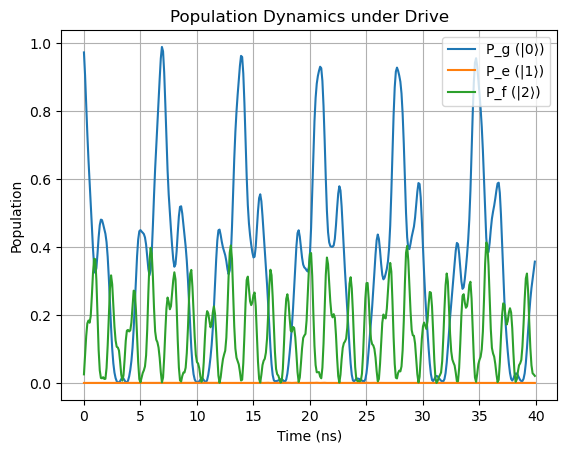

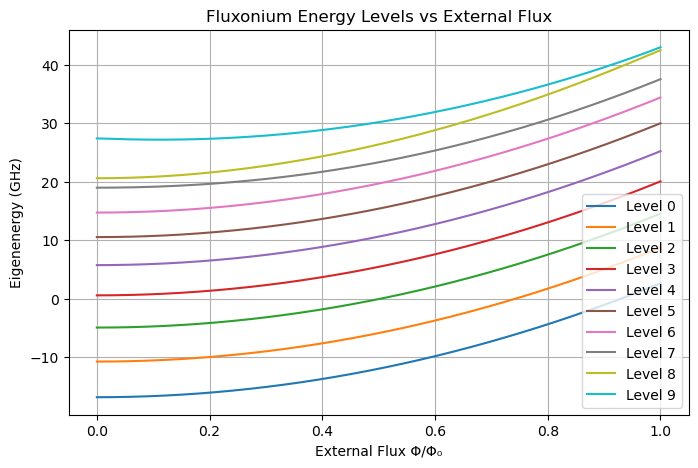

In [3]:
# Jupyter Notebook: Driven Qubit Dynamics Simulation

## Step 1: Import Libraries
import numpy as np
from scipy.sparse import diags
from scipy.linalg import expm
import matplotlib.pyplot as plt

## Step 2: Static Hamiltonian Construction
def build_static_hamiltonian(EC, EJ, EL, N, n_cutoff=20, phi_ext=0.0):
    n_vals = np.arange(-n_cutoff, n_cutoff + 1)
    dim = len(n_vals)
    n_op = diags(n_vals, 0).toarray()
    exp_i_phi = diags([np.ones(dim - 1)], [1], shape=(dim, dim)).toarray()
    exp_minus_i_phi = diags([np.ones(dim - 1)], [-1], shape=(dim, dim)).toarray()
    cos_phi_op = 0.5 * (exp_i_phi + exp_minus_i_phi)
    phi_vals = np.linspace(-np.pi, np.pi, dim)
    phi_op = diags(phi_vals, 0).toarray()
    phi_shift = phi_op - 2 * np.pi * phi_ext * np.eye(dim)
    H0 = 4 * EC * (n_op @ n_op) + EJ * cos_phi_op + 0.5 * EL * (phi_shift @ phi_shift)
    evals, evecs = np.linalg.eigh(H0)
    evals = evals[:N]
    evecs = evecs[:, :N]
    n_op_trunc = evecs.T @ n_op @ evecs
    phi_op_trunc = evecs.T @ phi_op @ evecs
    return evals, evecs, n_op_trunc, phi_op_trunc

## Step 3: Define Drive Flux Function
def phi_drive(t, phi_amp, omega_d, envelope_fn):
    return 2 * np.pi * phi_amp * envelope_fn(t) * np.cos(2 * np.pi * omega_d * t)

def sine_squared_envelope(t, t_pulse):
    return np.sin(np.pi * t / t_pulse)**2 if 0 <= t <= t_pulse else 0.0

## Step 4: Time-Dependent Hamiltonian
def H_time_dependent(phi_t, EC, EJ, EL, n_op, phi_op):
    H_static = 4 * EC * (n_op @ n_op) + EJ * expm(1j * phi_op).real
    phi_shift = phi_op - phi_t * np.eye(phi_op.shape[0])
    H_drive = 0.5 * EL * (phi_shift @ phi_shift)
    return H_static + H_drive

## Step 5: Time Evolution Step
def time_evolve_step(psi_t, H_t, dt):
    U = expm(-1j * H_t * dt)
    return U @ psi_t

## Step 6: Full Simulation Function
def simulate_time_evolution(psi_0, times, phi_amp, omega_d, envelope_fn,
                            EC, EJ, EL, n_op, phi_op):
    psi_t = psi_0.copy()
    for t in times:
        phi_t = phi_drive(t, phi_amp, omega_d, envelope_fn)
        H_t = H_time_dependent(phi_t, EC, EJ, EL, n_op, phi_op)
        dt = times[1] - times[0]
        psi_t = time_evolve_step(psi_t, H_t, dt)
        psi_t /= np.linalg.norm(psi_t)
    return psi_t

## Step 7: Measure State Populations
def excited_state_population(psi_final, excited_state):
    return np.abs(np.vdot(excited_state, psi_final))**2

## Step 8: Explore Dynamics of |g>, |e>, |f>
def explore_dynamics(psi_0, evecs, times, phi_amp, omega_d, envelope_fn,
                     EC, EJ, EL, n_op, phi_op):
    psi_t = psi_0.copy()
    P_g, P_e, P_f = [], [], []
    for t in times:
        phi_t = phi_drive(t, phi_amp, omega_d, envelope_fn)
        H_t = H_time_dependent(phi_t, EC, EJ, EL, n_op, phi_op)
        dt = times[1] - times[0]
        psi_t = time_evolve_step(psi_t, H_t, dt)
        psi_t /= np.linalg.norm(psi_t)
        P_g.append(np.abs(psi_t[0])**2)
        P_e.append(np.abs(psi_t[1])**2)
        P_f.append(np.abs(psi_t[2])**2)
    return times, np.array(P_g), np.array(P_e), np.array(P_f)

## Step 9: Simulation Parameters and Run
EC = 0.25
EJ = 20.0
EL = 1.0
N = 10
phi_amp = 0.5
t_pulse = 40
omega_d = 5.8
envelope = lambda t: sine_squared_envelope(t, t_pulse)
evals, evecs, n_op_trunc, phi_op_trunc = build_static_hamiltonian(EC, EJ, EL, N)
psi_0_trunc = evecs.T @ evecs[:, 0]
times = np.arange(0, t_pulse, 0.1)
t_ns, P_g, P_e, P_f = explore_dynamics(
    psi_0=psi_0_trunc,
    evecs=evecs,
    times=times,
    phi_amp=phi_amp,
    omega_d=omega_d,
    envelope_fn=envelope,
    EC=EC,
    EJ=EJ,
    EL=EL,
    n_op=n_op_trunc,
    phi_op=phi_op_trunc
)

## Step 10: Plot Results
plt.plot(t_ns, P_g, label="P_g (|0⟩)")
plt.plot(t_ns, P_e, label="P_e (|1⟩)")
plt.plot(t_ns, P_f, label="P_f (|2⟩)")
plt.xlabel("Time (ns)")
plt.ylabel("Population")
plt.title("Population Dynamics under Drive")
plt.legend()
plt.grid(True)
plt.show()

## Step 11: Fluxonium Spectrum vs External Flux
phi_exts = np.linspace(0, 1, 200)
levels = []

for phi in phi_exts:
    evals, *_ = build_static_hamiltonian(EC, EJ, EL, N, phi_ext=phi)
    levels.append(evals)

levels = np.array(levels)

plt.figure(figsize=(8, 5))
for i in range(N):
    plt.plot(phi_exts, levels[:, i], label=f"Level {i}")

plt.xlabel("External Flux Φ/Φ₀")
plt.ylabel("Eigenenergy (GHz)")
plt.title("Fluxonium Energy Levels vs External Flux")
plt.grid(True)
plt.legend()
plt.show()


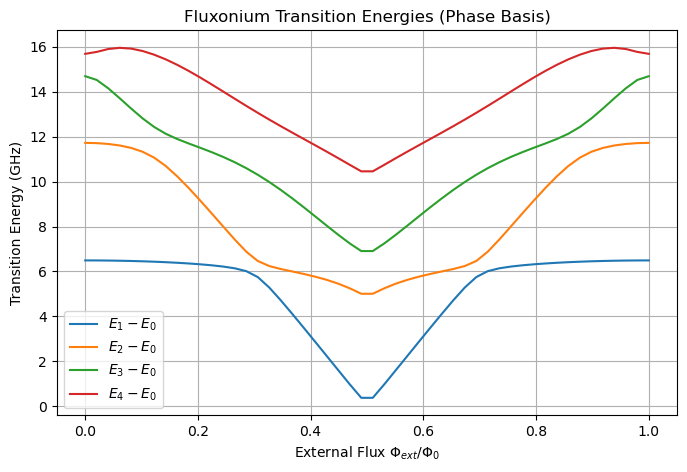

In [5]:
# Implementing the fluxonium Hamiltonian in the phase basis (finite-difference method):
# H = -4EC d²/dphi² - EJ cos(phi - phi_ext) + (1/2) EL phi²

def build_fluxonium_phase_basis(EC, EJ, EL, N=5, phi_min=-6*np.pi, phi_max=6*np.pi, num_pts=200, phi_ext=0.0):
    """
    Constructs the fluxonium Hamiltonian in the phase basis using finite differences.

    Parameters:
    - EC, EJ, EL: energies (GHz)
    - N: number of levels to return
    - phi_min, phi_max: range of phase grid
    - num_pts: number of grid points
    - phi_ext: external flux in units of Phi_0

    Returns:
    - evals: first N eigenenergies
    """
    # Grid
    phi = np.linspace(phi_min, phi_max, num_pts)
    dphi = phi[1] - phi[0]
    dim = len(phi)

    # Second derivative operator (finite difference for kinetic term)
    kinetic = (-2 * np.eye(dim) + np.eye(dim, k=1) + np.eye(dim, k=-1)) / dphi**2
    T = -4 * EC * kinetic

    # Potential energy: cosine + quadratic
    V = -EJ * np.cos(phi - 2 * np.pi * phi_ext) + 0.5 * EL * phi**2
    V_matrix = np.diag(V)

    H = T + V_matrix
    evals, _ = np.linalg.eigh(H)
    return evals[:N]

# Sweep phi_ext from 0 to 1 and collect spectrum
phi_ext_list = np.linspace(0, 1, 50)
EC, EJ, EL, N = 1.0, 6.0, 1.0, 5
all_levels_phase = []

for phi_ext in phi_ext_list:
    levels = build_fluxonium_phase_basis(EC, EJ, EL, N, phi_ext=phi_ext)
    all_levels_phase.append(levels)

all_levels_phase = np.array(all_levels_phase)
transition_energies_phase = all_levels_phase - all_levels_phase[:, [0]]

# Plot transition energies from phase basis
plt.figure(figsize=(8, 5))
for i in range(1, N):
    plt.plot(phi_ext_list, transition_energies_phase[:, i], label=f"$E_{i} - E_0$")

plt.xlabel("External Flux $\Phi_{ext} / \Phi_0$")
plt.ylabel("Transition Energy (GHz)")
plt.title("Fluxonium Transition Energies (Phase Basis)")
plt.grid(True)
plt.legend()
plt.show()


In [8]:
import numpy as np
from scipy.linalg import eigh

def get_fluxonium_wavefunctions(EC, EJ, EL, phi_ext, N=5, phi_min=-6*np.pi, phi_max=6*np.pi, num_pts=200):
    """
    Compute eigenenergies and wavefunctions of fluxonium in phase basis.

    Parameters:
    - EC, EJ, EL: charging energy, Josephson energy, inductive energy (in GHz)
    - phi_ext: external flux in units of Phi_0
    - N: number of eigenstates to return
    - phi_min, phi_max: phase space range (in radians)
    - num_pts: number of discretization points

    Returns:
    - phi_vals: array of phase values
    - evals: first N eigenenergies
    - evecs: corresponding eigenfunctions, shape (num_pts, N)
    """
    # Phase grid
    phi_vals = np.linspace(phi_min, phi_max, num_pts)
    dphi = phi_vals[1] - phi_vals[0]

    # Kinetic energy (second derivative operator)
    T = -4 * EC * (
        -2 * np.eye(num_pts) +
        np.eye(num_pts, k=1) +
        np.eye(num_pts, k=-1)
    ) / dphi**2

    # Potential energy: shifted cosine + quadratic inductive term
    V = -EJ * np.cos(phi_vals - 2 * np.pi * phi_ext) + 0.5 * EL * phi_vals**2
    V_matrix = np.diag(V)

    # Total Hamiltonian
    H = T + V_matrix

    # Solve
    evals, evecs = eigh(H)
    return phi_vals, evals[:N], evecs[:, :N]


In [9]:
phi_vals, energies, wavefuncs = get_fluxonium_wavefunctions(EC=1.0, EJ=6.0, EL=1.0, phi_ext=0.5)


In [10]:
import numpy as np

def compute_matrix_elements(phi_vals, wavefuncs):
    """
    Compute matrix elements <i|phi|j> and <i|n|j> in the phase basis.

    Parameters:
    - phi_vals: 1D array of phase grid points
    - wavefuncs: 2D array of shape (len(phi_vals), N) with N wavefunctions

    Returns:
    - matrix_phi: <i|phi|j> matrix (NxN)
    - matrix_n: <i|n|j> matrix (NxN)
    """
    dphi = phi_vals[1] - phi_vals[0]
    dim = len(phi_vals)
    N = wavefuncs.shape[1]

    # Phase operator is diagonal
    phi_op = np.diag(phi_vals)

    # Hermitian central-difference derivative for charge operator
    off_diag = np.ones(dim - 1)
    deriv_matrix = (
        np.diag(-off_diag, -1) +
        np.diag(off_diag, 1)
    ) / (2 * dphi)
    n_op = -1j * deriv_matrix

    # Project to eigenbasis
    matrix_phi = wavefuncs.T @ phi_op @ wavefuncs
    matrix_n = wavefuncs.T @ n_op @ wavefuncs

    return matrix_phi, matrix_n


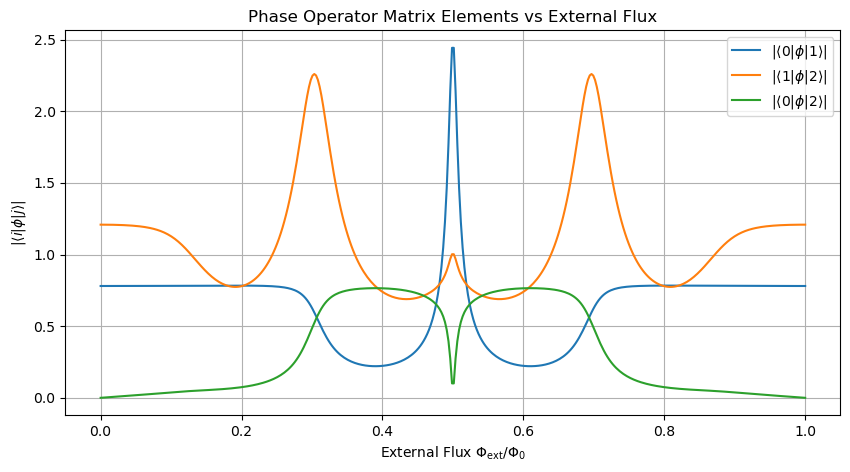

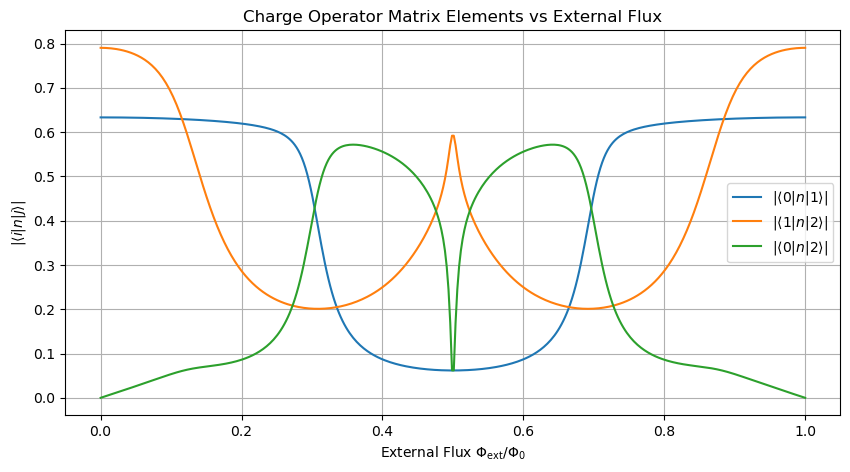

In [13]:
# Fixing the missing argument: compute dphi and pass it in

# Prepare storage
phi_ext_sweep = np.linspace(0, 1, 400)
phi_01_vals, phi_12_vals, phi_02_vals = [], [], []
n_01_vals, n_12_vals, n_02_vals = [], [], []

# Sweep phi_ext and compute matrix elements
for phi_ext in phi_ext_sweep:
    phi_vals, energies, wavefuncs = get_fluxonium_wavefunctions(EC, EJ, EL, phi_ext=phi_ext, N=5)
    dphi = phi_vals[1] - phi_vals[0]
    matrix_phi, matrix_n = compute_matrix_elements(phi_vals, wavefuncs)

    phi_01_vals.append(np.abs(matrix_phi[0, 1]))
    phi_12_vals.append(np.abs(matrix_phi[1, 2]))
    phi_02_vals.append(np.abs(matrix_phi[0, 2]))

    n_01_vals.append(np.abs(matrix_n[0, 1]))
    n_12_vals.append(np.abs(matrix_n[1, 2]))
    n_02_vals.append(np.abs(matrix_n[0, 2]))

# Plot |<i|phi|j>|
plt.figure(figsize=(10, 5))
plt.plot(phi_ext_sweep, phi_01_vals, label=r"$|\langle 0 | \phi | 1 \rangle|$")
plt.plot(phi_ext_sweep, phi_12_vals, label=r"$|\langle 1 | \phi | 2 \rangle|$")
plt.plot(phi_ext_sweep, phi_02_vals, label=r"$|\langle 0 | \phi | 2 \rangle|$")
plt.xlabel(r"External Flux $\Phi_{\rm ext}/\Phi_0$")
plt.ylabel(r"$|\langle i | \phi | j \rangle|$")
plt.title("Phase Operator Matrix Elements vs External Flux")
plt.legend()
plt.grid(True)
plt.show()

# Plot |<i|n|j>|
plt.figure(figsize=(10, 5))
plt.plot(phi_ext_sweep, n_01_vals, label=r"$|\langle 0 | n | 1 \rangle|$")
plt.plot(phi_ext_sweep, n_12_vals, label=r"$|\langle 1 | n | 2 \rangle|$")
plt.plot(phi_ext_sweep, n_02_vals, label=r"$|\langle 0 | n | 2 \rangle|$")
plt.xlabel(r"External Flux $\Phi_{\rm ext}/\Phi_0$")
plt.ylabel(r"$|\langle i | n | j \rangle|$")
plt.title("Charge Operator Matrix Elements vs External Flux")
plt.legend()
plt.grid(True)
plt.show()
